Лабораторная работа № 8. Динамические сети

Выполнил: Степанов Данила Михайлович

Группа: М8О-407Б-20

Вариант: 22

Цель работы:

Целью работы является исследование свойств некоторых динамических нейронных сетей,
алгоритмов обучения, а также применение сетей в задачах аппроксимации функций и распозна-
вания динамических образов

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Управляющий сигнал согласно варианту задания

In [2]:
rule_signal = lambda k: np.sin(-k ** 2 + 2)

Функция для генерации данных

In [3]:
def generate_data(rule_signal, start, finish, step, return_tensors=False):
  seq_len = int((finish - start) / step + 1)
  y = [0 for i in range(seq_len)]
  y[0] = 0
  k_values = [i * step for i in range(seq_len)]
  u = [0 for i in range(seq_len)]
  u[0] = rule_signal(0)

  for k in range(1, seq_len):
    y[k] = y[k - 1] / (1 + y[k - 1] ** 2) + u[k - 1] ** 3
    u[k] = rule_signal(k_values[k])

  if return_tensors:
    return torch.reshape(torch.tensor(u, dtype=torch.float), (seq_len, 1)), torch.reshape(torch.tensor(y, dtype=torch.float), (seq_len, 1))
  else:
    return u, y

In [4]:
u, y = generate_data(rule_signal, 0, 10, 0.01, return_tensors=True)

Отобразим последовательность значений y и управляющий сигнал

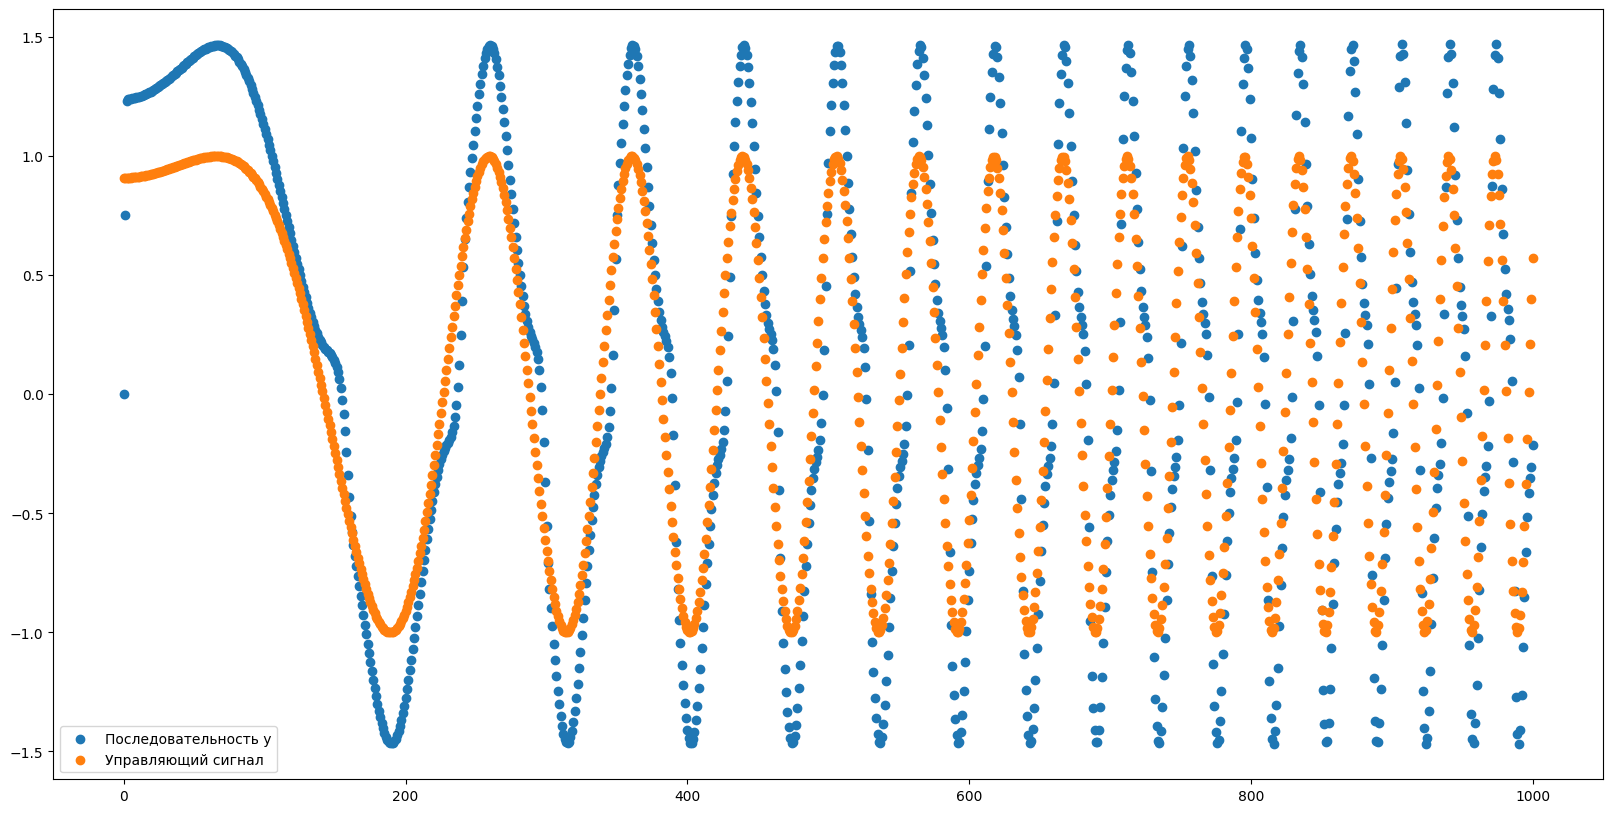

In [5]:
plt.figure(figsize=(20, 10))

plt.scatter(range(1001), y)
plt.scatter(range(1001), u)
plt.legend(["Последовательность y", "Управляющий сигнал"])

Опишем архитектуру сети NARX

In [6]:
class NARX(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, delay1, delay2):
    super().__init__()
    self.delay1 = delay1
    self.output_size = output_size
    self.delay2 = delay2
    self.tanh = nn.Tanh()
    self.lin = nn.Linear(delay2, 1)
    self.W1 = nn.Parameter(torch.randn(input_size, hidden_size))
    self.W2 = nn.Parameter(torch.randn(output_size, hidden_size))
    self.b1 = nn.Parameter(torch.randn(hidden_size))
    self.W3 = nn.Parameter(torch.randn(hidden_size, output_size))
    self.b2 = nn.Parameter(torch.randn(output_size))

  def forward(self, u, y):
    outputs = torch.zeros(u.shape[0] - self.delay1, self.output_size)
    for index in range(self.delay1, u.shape[0] - self.delay1):
      output = (self.tanh(y[index:index + self.delay1] @ self.W1 + u[index:index + self.delay2] @ self.W2 + self.b1) @ self.W3 + self.b2).T
      output = self.lin(output)
      outputs[index, :] = output
    return outputs



Опишем модель, функцию потерь и оптимизатор для обучения модели

In [7]:
epochs = 100

model = NARX(1, 10, 1, 3, 3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Опишем цикл обучения

In [8]:
def train(model, u, y, criterion, optimizer, epochs=10):
  model.train()
  history = []
  for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(u, y)
    loss = criterion(outputs, y[model.delay1:])
    if epoch % 50 == 0:
      print(f"epoch: {epoch}, loss: {loss.item()}")
    history.append(loss.item())
    loss.backward()
    optimizer.step()

  return history

In [9]:
history = train(model, u, y, criterion, optimizer, epochs=epochs)

epoch: 0, loss: 1.3371047973632812
epoch: 50, loss: 0.09039277583360672


Отобразим кривую обучения

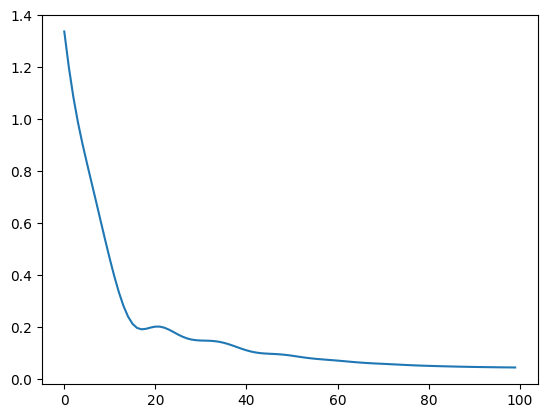

In [10]:
plt.plot(range(epochs), history)

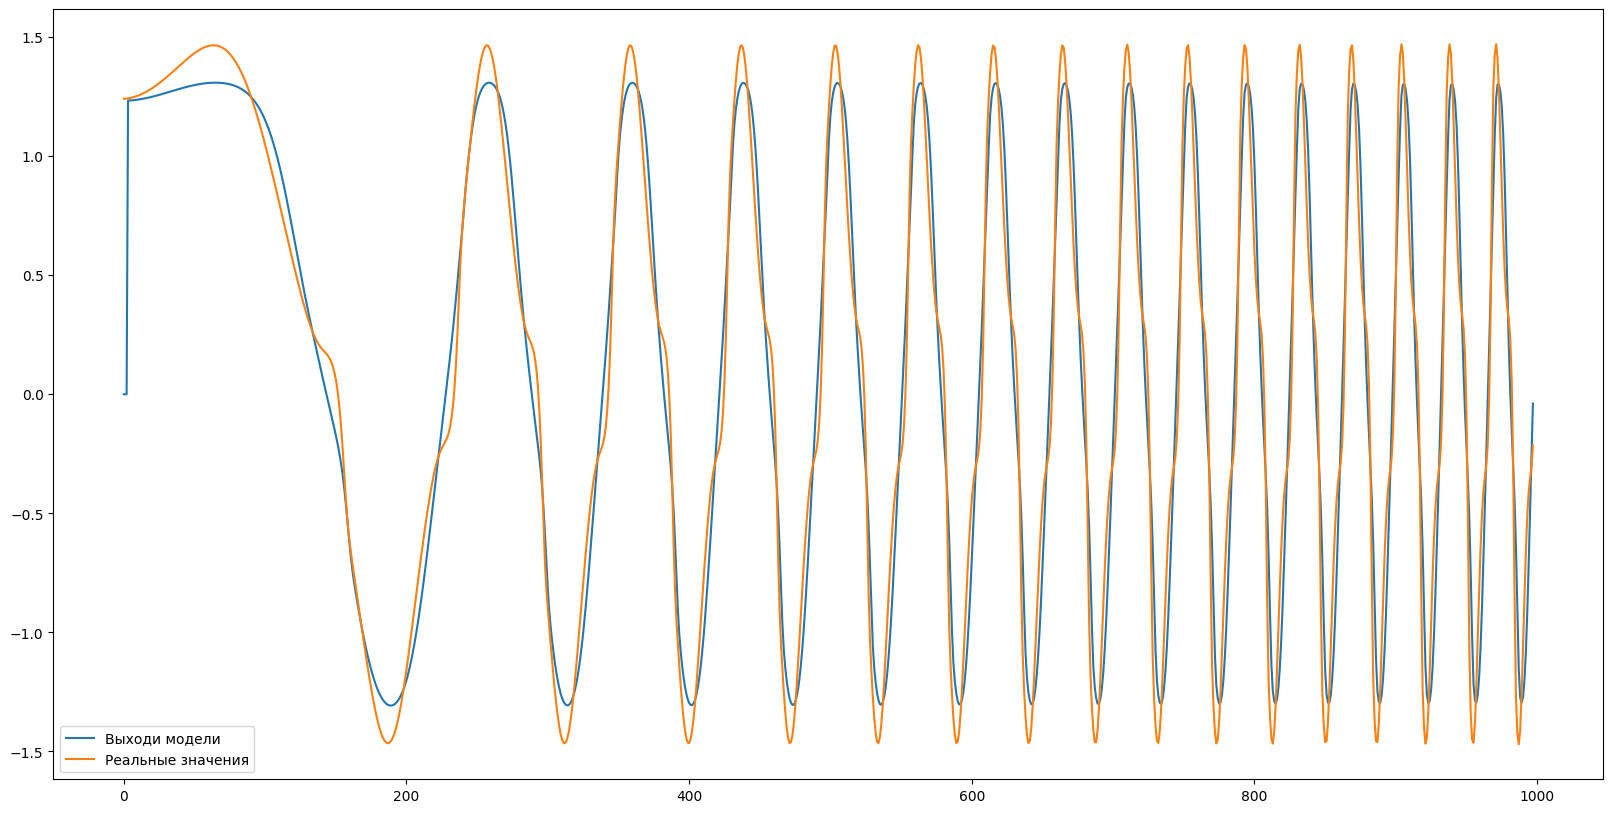

In [13]:
outputs = model(u, y)
outputs = outputs.clone().detach().cpu()
plt.figure(figsize=(20, 10))
plt.plot(range(len(outputs)), outputs)
plt.plot(range(len(outputs)), y[model.delay1:])
plt.legend(["Выходи модели", "Реальные значения"])

Вывод:
Динамические сети являются мощным инструментом для прогнозирования временных рядов. Особенностью сети NARX является учёт внешних переменных, что просто необходимо в таких задачах как прогнозирование цен на акции. Недостатком такой сети является её сложность: чтобы хорошо её обучить, нужно подготовить много данных.